Load Libraries

In [79]:
!pip install biopython seaborn
%pip install biopython
%pip install seaborn
!pip install -q biopython transformers datasets huggingface_hub accelerate

import os
import zipfile
import torch
import random
import sys

import matplotlib.pyplot as plt
import numpy as np

from Bio import SeqIO, Entrez
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from datasets import Dataset
from itertools import product
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BertForSequenceClassification, BertTokenizer
from tqdm import tqdm

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

# Verify wandb is disabled
print("WANDB_DISABLED:", os.environ.get("WANDB_DISABLED"))

WANDB_DISABLED: true


Seeding

In [80]:
seed = 77

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Clone DNABERT6 Repository

In [81]:
# Install necessary libraries
!pip install torch torchvision transformers datasets gdown

# Clone the DNA-BERT repository
!git clone https://github.com/jerryji1993/DNABERT.git


fatal: destination path 'DNABERT' already exists and is not an empty directory.


NB!!! upload zip file (6-new-12w-0.zip) before continuing else code won't run




In [82]:
# Path to the uploaded zip file
uploaded_zip_path = '/content/6-new-12w-0.zip'

# Define the directory for extraction
PRETRAINED_DIR = "/content/DNABERT/pretrained/dna6"
os.makedirs(PRETRAINED_DIR, exist_ok=True)  # Attempt to create the directory

# Extract the zip file
try:
    with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
        zip_ref.extractall(PRETRAINED_DIR)
    print(f"Extracted DNA-BERT files to: {PRETRAINED_DIR}")
except PermissionError as e:
    print(f"Permission denied: {e}. Check your permissions for '/content'.")
except Exception as e:
    print(f"An error occurred: {e}")


Extracted DNA-BERT files to: /content/DNABERT/pretrained/dna6


Clone Seminar Repository

In [83]:
directory = "seminar-dlmb-2024-winter-public"

if os.path.exists(directory) and os.listdir(directory):
    print(f"Directory {directory} exists and is non-empty.")
else:
    print(f"Directory {directory} does not exist or is empty.")
    !!git clone https://github.com/hzi-bifo/seminar-dlmb-2024-winter-public.git

Directory seminar-dlmb-2024-winter-public exists and is non-empty.


In [84]:
# Define the working device
device = torch.device("cuda")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA A100-SXM4-40GB is available.


Create Datasets

In [85]:
# Paths
base_path = "seminar-dlmb-2024-winter-public/"
data_path = "seminar-dlmb-2024-winter-public/data/ds1"

sys.path.append('seminar-dlmb-2024-winter-public/src/')
from amr.amr_utility import load_gene_data, create_gene_datasets

# Create datasets
create_gene_datasets(base_path, data_path)

# Load dataset
ds = load_gene_data(data_path, "Staphylococcus_aureus_cefoxitin", "pbp4")

sequences_train = [x[1] for x in ds["train"]]
labels_train = [x[2] for x in ds["train"]]

sequences_test = [x[1] for x in ds["test"]]
labels_test = [x[2] for x in ds["test"]]

sequences = sequences_train + sequences_test
labels = labels_train + labels_test

# Separate data by classes
class_0 = [(seq, label) for seq, label in zip(sequences, labels) if label == 0]
class_1 = [(seq, label) for seq, label in zip(sequences, labels) if label == 1]

random.shuffle(class_0)
random.shuffle(class_1)

test_data = class_0[:7] + class_1[:7]
leftover_class_0 = class_0[7:]
leftover_class_1 = class_1[7:]

val_data = leftover_class_0[:7] + leftover_class_1[:7]
leftover_class_0 = leftover_class_0[7:]
leftover_class_1 = leftover_class_1[7:]

train_data = leftover_class_0 + leftover_class_1

# Split train, val, and test data into sequences and labels
sequences_train = [seq for seq, label in train_data]
labels_train = [label for seq, label in train_data]

sequences_val = [seq for seq, label in val_data]
labels_val = [label for seq, label in val_data]

sequences_test = [seq for seq, label in test_data]
labels_test = [label for seq, label in test_data]


In [86]:
%cd /content/DNABERT/pretrained/

!ls -l /content/DNABERT/pretrained/

!mv /content/DNABERT/pretrained/dna6/6-new-12w-0/* /content/DNABERT/pretrained/dna6/

!rm -rf /content/DNABERT/pretrained/dna6/6-new-12w-0

!ls -l /content/DNABERT/pretrained/dna6

/content/DNABERT/pretrained
total 12
drwxr-xr-x 3 root root 4096 Jan  7 21:52 dna6
drwxr-xr-x 7 root root 4096 Jan  7 21:36 DNABERT
drwxr-xr-x 5 root root 4096 Jan  7 21:36 seminar-dlmb-2024-winter-public
total 350828
-rw-r--r-- 1 root root      1110 Jan  7 21:52 config.json
-rw-r--r-- 1 root root 359199902 Jan  7 21:52 pytorch_model.bin
-rw-r--r-- 1 root root       112 Jan  7 21:52 special_tokens_map.json
-rw-r--r-- 1 root root        40 Jan  7 21:52 tokenizer_config.json
-rw-r--r-- 1 root root     28703 Jan  7 21:52 vocab.txt


In [102]:
class SEQTokenizer_Kmers:
    """Custom tokenizer for DNA sequences with k-mers, truncation, and padding."""
    def __init__(self, k, max_length=512, pad_token_id=0):
        self.k = k
        self.max_length = max_length
        self.pad_token_id = pad_token_id

        # Create vocabulary of all possible k-mers
        self.vocab = [''.join(kmer) for kmer in product('ATCG', repeat=k)]
        self.token_to_id = {token: i for i, token in enumerate(self.vocab)}

    def encode(self, sequence):
        """
        Tokenizes the input sequence into k-mers and maps them to token IDs.
        Pads and truncates the tokenized output to max_length.

        Args:
            sequence (str): Input DNA sequence.

        Returns:
            List[int]: Tokenized sequence with padding and truncation applied.
        """
        # Generate k-mers and convert to token IDs
        kmers = [sequence[i:i+self.k] for i in range(len(sequence) - self.k + 1)]
        token_ids = [self.token_to_id[kmer] for kmer in kmers if kmer in self.token_to_id]

        # Truncate to max_length
        token_ids = token_ids[:self.max_length]

        # Pad if the sequence is shorter than max_length
        if len(token_ids) < self.max_length:
            token_ids += [self.pad_token_id] * (self.max_length - len(token_ids))

        return token_ids

tokenizer = SEQTokenizer_Kmers(k=6)

In [103]:
# Tokenize the datasets using the encode method
train_tokenized = [tokenizer.encode(seq) for seq in sequences_train]
test_tokenized = [tokenizer.encode(seq) for seq in sequences_test]
val_tokenized = [tokenizer.encode(seq) for seq in sequences_val]

# Convert the tokenized data into Hugging Face Dataset objects
train_dataset = Dataset.from_dict({"input_ids": train_tokenized})
test_dataset = Dataset.from_dict({"input_ids": test_tokenized})
val_dataset = Dataset.from_dict({"input_ids": val_tokenized})

# Add the labels to each dataset
train_dataset = train_dataset.add_column("labels", labels_train)
test_dataset = test_dataset.add_column("labels", labels_test)
val_dataset = val_dataset.add_column("labels", labels_val)

# Shuffle the datasets
train_dataset = train_dataset.shuffle(seed=seed)
test_dataset = test_dataset.shuffle(seed=seed)
val_dataset = val_dataset.shuffle(seed=seed)

# Print the first training example
print(train_dataset[0])

{'input_ids': [1109, 342, 1369, 1381, 1429, 1621, 2389, 1366, 1369, 1380, 1424, 1600, 2305, 1028, 16, 64, 258, 1035, 44, 177, 709, 2839, 3164, 369, 1477, 1812, 3153, 326, 1304, 1121, 388, 1553, 2119, 284, 1136, 450, 1800, 3104, 129, 517, 2068, 83, 333, 1335, 1246, 889, 3556, 1936, 3649, 2310, 1050, 104, 419, 1678, 2619, 2284, 946, 3785, 2852, 3219, 591, 2366, 1272, 993, 3975, 3614, 2168, 482, 1930, 3624, 2210, 650, 2600, 2208, 641, 2567, 2076, 113, 452, 1811, 3149, 311, 1244, 880, 3521, 1796, 3088, 65, 263, 1055, 124, 497, 1991, 3869, 3189, 470, 1881, 3431, 1438, 1658, 2538, 1960, 3746, 2696, 2593, 2180, 530, 2121, 293, 1173, 597, 2388, 1363, 1358, 1336, 1248, 898, 3592, 2083, 141, 564, 2257, 837, 3349, 1111, 350, 1402, 1513, 1957, 3733, 2645, 2391, 1372, 1392, 1473, 1796, 3088, 65, 261, 1047, 95, 382, 1529, 2023, 3996, 3697, 2503, 1820, 3184, 450, 1801, 3109, 150, 601, 2404, 1426, 1608, 2339, 1165, 565, 2263, 863, 3452, 1523, 1999, 3901, 3318, 986, 3944, 3489, 1668, 2576, 2113, 262, 1

In [104]:
# Print the sequence lenghts of all available sequences
all_sequences = sequences_train + sequences_test + sequences_val

seq_lengths = [len(seq) for seq in all_sequences]
print(seq_lengths)

[1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296]


In [105]:
# Get labels from the training dataset
labels = train_dataset["labels"]

# Compute class weights so classes seem balanced
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights_tensor)

Class Weights: tensor([2.3462, 0.6354])


In [106]:
# Define a custom model with weighted loss
class WeightedModel(torch.nn.Module):
    def __init__(self, model_name, class_weights):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(class_weights))
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Initialize the model with class weights
model = WeightedModel("/content/DNABERT/pretrained/dna6", class_weights_tensor)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/DNABERT/pretrained/dna6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
def create_kmer_vocab(k):
    # Generate all possible k-mers using the alphabet "A", "T", "C", "G"
    alphabet = "ATCG"
    kmers = [''.join(p) for p in product(alphabet, repeat=k)]
    return kmers

# Set k-mer size
k = 6

# Generate vocabulary
vocab = create_kmer_vocab(k)

# Save the vocabulary to a file
vocab_file_path = "/content/DNABERT/pretrained/dna6/vocab.txt"
with open(vocab_file_path, "w") as f:
    f.write("\n".join(vocab))

print(f"Vocabulary file created at: {vocab_file_path}")

# Load the tokenizer with the new vocabulary file
tokenizer = BertTokenizer.from_pretrained(
    "/content/DNABERT/pretrained/dna6",
    vocab_file="/content/DNABERT/pretrained/dna6/vocab.txt"
)

Vocabulary file created at: /content/DNABERT/pretrained/dna6/vocab.txt


In [108]:
OUTPUT_PATH = "/content/DNABERT/output"  # Define a permanent output directory

training_args = TrainingArguments(
    output_dir=OUTPUT_PATH,  # Save outputs to a permanent directory
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    logging_strategy="epoch",     # Log training/validation loss every epoch
    save_strategy="epoch",        # Save checkpoints at the end of each epoch
    save_total_limit=1,           # Keep the last checkpoint
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs=100,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_PATH}/logs",
)

os.makedirs(OUTPUT_PATH, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [109]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

<ipython-input-109-373c322edf99>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [110]:
# Train the model
print("Starting training...")
trainer.train()

# Evaluate the model
print("Evaluating model on test set...")
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Starting training...


RuntimeError: The expanded size of the tensor (1024) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [16, 1024].  Tensor sizes: [1, 512]

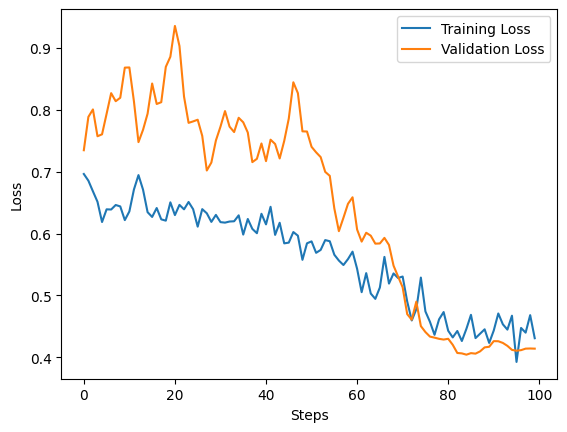

101


In [96]:
history = trainer.state.log_history

train_loss = [log["loss"] for log in history if "loss" in log]
val_loss = [log["eval_loss"] for log in history if "eval_loss" in log]

plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss[:-1], label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.xlim(0, len(train_loss))
plt.ylim(0, max(max(train_loss), max(val_loss)))
plt.legend()
plt.show()

print(len(val_loss))

In [97]:
predictions = trainer.predict(test_dataset=test_dataset)
print(predictions.predictions)  # Raw logits

# Get predicted class labels from logits
predicted_classes = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Display the predicted class labels
print("Predicted Classes:", predicted_classes)
print("True Classes:", true_labels)    # True labels

def compute_metrics(true_labels, predicted_classes):
    precision = precision_score(true_labels, predicted_classes, average="weighted")
    recall = recall_score(true_labels, predicted_classes, average="weighted")
    f1 = f1_score(true_labels, predicted_classes, average="weighted")
    accuracy = accuracy_score(true_labels, predicted_classes)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

# Call the function
metrics = compute_metrics(true_labels, predicted_classes)

[[-0.6499603   0.55521446]
 [ 1.5008082  -1.6635929 ]
 [ 1.4878762  -1.655727  ]
 [-0.25183454  0.5187531 ]
 [-1.0500218   1.1115035 ]
 [-0.94915885  0.6651509 ]
 [-0.92325944  1.0611184 ]
 [-0.93974805  1.0556698 ]
 [-0.7638464   0.6111928 ]
 [ 1.5008082  -1.6635929 ]
 [-0.75686795  0.61362237]
 [-0.93974805  1.0556698 ]
 [-1.0474267   1.1040477 ]
 [-0.94915885  0.6651509 ]]
Predicted Classes: [1 0 0 1 1 1 1 1 1 0 1 1 1 1]
True Classes: [1 0 0 0 1 1 0 1 0 0 0 1 1 1]
Precision: 0.8182
Recall: 0.7143
F1 Score: 0.6889
Accuracy: 0.7143


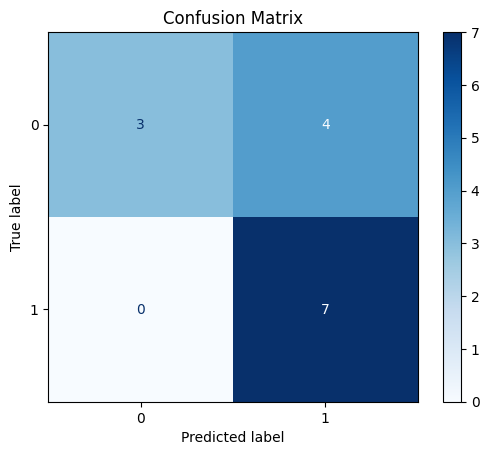

In [98]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])  # Adjust for more classes
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [99]:
# Generate detailed class-wise metrics
class_report = classification_report(true_labels, predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.43      0.60         7
     Class 1       0.64      1.00      0.78         7

    accuracy                           0.71        14
   macro avg       0.82      0.71      0.69        14
weighted avg       0.82      0.71      0.69        14



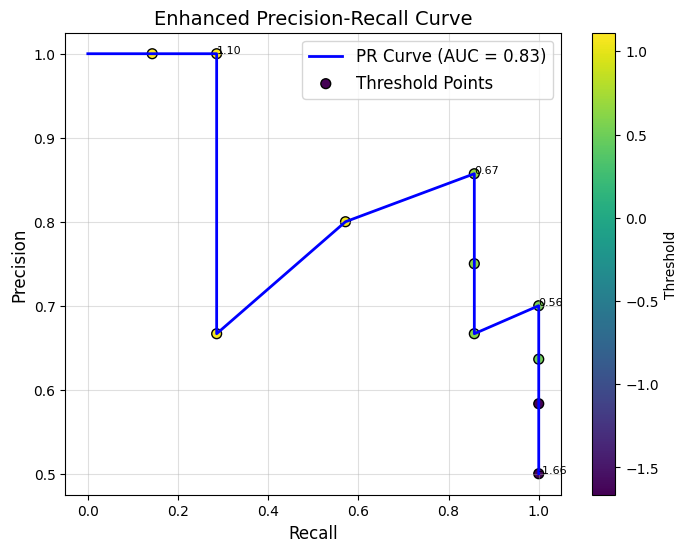

In [100]:
# Assuming binary classification and raw logits
probabilities = predictions.predictions[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)

# Calculate the area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue', lw=2)

# Highlight threshold points with a larger marker size
plt.scatter(recall[:-1], precision[:-1], c=thresholds, cmap='viridis', s=50, edgecolor='k', label='Threshold Points')

# Annotate thresholds for clarity (every 3rd point)
for i in range(0, len(thresholds), 3):
    plt.text(recall[i], precision[i], f'{thresholds[i]:.2f}', fontsize=8, color='black')

# Enhancements
plt.colorbar(label='Threshold')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Enhanced Precision-Recall Curve', fontsize=14)
plt.grid(alpha=0.4)
plt.legend(fontsize=12)
plt.show()


In [101]:
# Analyze class distribution
unique, counts = np.unique(true_labels, return_counts=True)
print("Class Distribution:", dict(zip(unique, counts)))

Class Distribution: {0: 7, 1: 7}
